# Space Environment Pathways
This Jupyter Notebook will allow users to play around with the scenarios, in order to get to know the laucnh data.

If you would like to use the scen_properties of a pickle file, then this must be located under the first pyssem folder. In the same folder as model.py

In [ ]:
import pandas as pd
    
path = '/Users/isabellavesely/Downloads/SEP_files/ref_scen_SEP3H.csv' # your path to the scenario csv file
T = pd.read_csv(path)

# Only use if required, you can run the model, it will save a pickle file and then you can use this to get the scenario data. 
# import pickle
# with open('../scenario-properties-baseline.pkl', 'rb') as f:
#     scen_properties = pickle.load(f)

/var/folders/9y/hnc2c1bs54b27pqfzbnxv55r0000gn/T/ipykernel_26902/4015070235.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  T = pd.read_csv(path)


In [66]:
T_3H = T

path_good = '/Users/isabellavesely/Downloads/SEP_files/ref_scen_SEP1.csv' # your path to the scenario csv file
T = pd.read_csv(path_good)

Show all of the columns available, the data types and an example:

In [67]:
# print each column name, the data type and an example
for col in T.columns:
    print(f"Column: {col}")
    print(f"Data Type: {T[col].dtype}")
    print(f"Example: {T[col].iloc[0]}")
    print()

Column: obj_id
Data Type: int64
Example: 1

Column: phase_desc
Data Type: object
Example: debris/derelict

Column: phase
Data Type: int64
Example: 4

Column: par_id
Data Type: float64
Example: nan

Column: operating_agency
Data Type: float64
Example: nan

Column: const_name
Data Type: float64
Example: nan

Column: const_shell_id
Data Type: float64
Example: nan

Column: mass
Data Type: float64
Example: 1.47

Column: area
Data Type: float64
Example: 0.0214

Column: diam_lcola
Data Type: float64
Example: 0.165068

Column: diam_tumbl
Data Type: float64
Example: 0.131711

Column: diam_char
Data Type: float64
Example: 0.146674

Column: obj_type
Data Type: int64
Example: 2

Column: length
Data Type: float64
Example: nan

Column: width
Data Type: float64
Example: nan

Column: depth
Data Type: float64
Example: nan

Column: active
Data Type: float64
Example: 0.0

Column: maneuverable
Data Type: float64
Example: 0.0

Column: stkp_flg
Data Type: float64
Example: 0.0

Column: stkp_box_r
Data Type: 

In [93]:
# T.head()

### Isabella's Plotting

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

In [70]:
# This function has been taken for pyssem and allows you to pass a list of species queries and test it. 

def assign_species_to_population(T, species_mapping):
    """
    Applies a list of pandas query strings to assign species classes to the population.
    
    :param T: pandas.DataFrame representing the population
    :param species_mapping: list of assignment strings (e.g., T.loc[...] = ...)
    :return: updated DataFrame with 'species_class' assigned
    """
    # Initialize the column
    T['species_class'] = "Unknown"

    # Apply each mapping rule via exec
    for rule in species_mapping:
        try:
            exec(rule)
        except Exception as e:
            print(f"Error applying rule: {rule}\n\t{e}")

    # Print summary of resulting species_class assignments
    print("\nSpecies class distribution:")
    print(T['species_class'].value_counts())

    # Remove all objects that are still unknown
    try:
        T = T[T['species_class'] != "Unknown"]
        print(f"\n{T['species_class'].value_counts()['Unknown']} objects/rows are being removed.")
    except KeyError:
        print("No unknown species classes found.")

    return T

In [94]:
# Species configuration

species_configuration = [
      "T.loc[(T['phase'] == 2) & (T['obj_type'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'S'", # maneuverable
      "T.loc[(T['obj_type'] == 2) & (T['maneuverable'] == 0), 'species_class'] = 'Sns'", # non-maneuverable
      "T.loc[(T['obj_type'] >= 3), 'species_class'] = 'N'", # debris/derelect
      "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'" # rocket body
]

T_new = assign_species_to_population(T, species_configuration)

# remove all with phrase 3 (disposed)
T_new = T_new[T_new['phase'] != 3].copy()

# add radius column
T_new.loc[:, 'radius'] = T_new['diam_char'] / 2


Species class distribution:
species_class
N          54704
S           6906
Sns         3356
Unknown     2536
B           2082
Name: count, dtype: int64
No unknown species classes found.


## Time and Phase related study

In [95]:
# Filter to Sns
sns = T_new[T_new['species_class']=='Sns']
s = T_new[T_new['species_class']=='S']
n = T_new[T_new['species_class']=='N']
b = T_new[T_new['species_class']=='B']

print("\nPhase descriptions for Sns:")
print(sns['phase_desc'].value_counts())

print("\nPhase descriptions for S:")
print(s['phase_desc'].value_counts())

print("\nPhase descriptions for N:")
print(n['phase_desc'].value_counts())

print("\nPhase descriptions for B:")
print(b['phase_desc'].value_counts())



Phase descriptions for Sns:
phase_desc
debris/derelict    2422
Name: count, dtype: int64

Phase descriptions for S:
phase_desc
operations    6906
Name: count, dtype: int64

Phase descriptions for N:
phase_desc
debris/derelict    8943
Name: count, dtype: int64

Phase descriptions for B:
phase_desc
debris/derelict    1613
Name: count, dtype: int64


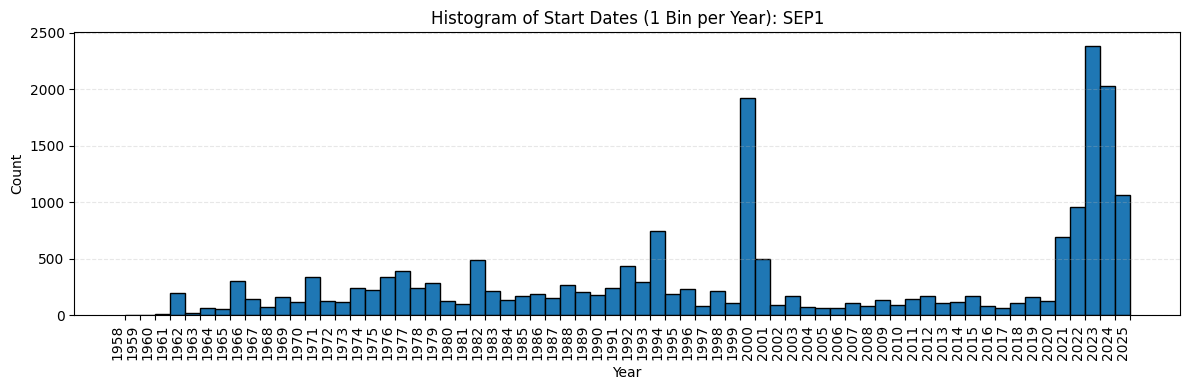

In [96]:
# 1) Build date_start if you haven’t already
T_new['date_start'] = pd.to_datetime({
    'year':  T_new.year_start.astype(int),
    'month': T_new.month_start.astype(int),
    'day':   T_new.day_start.astype(int)
})

# 2) Create yearly bins from min to max year
year_min = T_new['date_start'].dt.year.min()
year_max = T_new['date_start'].dt.year.max()
bins = pd.date_range(start=f"{year_min}-01-01", 
                     end=f"{year_max+1}-01-01", 
                     freq='YS')  # Year Start

# 3) Plot histogram with date bins
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(T_new['date_start'], bins=bins, edgecolor='black')

# 4) bin edges as ticks, label by year
ax.set_xticks(bins)
ax.set_xticklabels([dt.year for dt in bins], rotation=90, ha='right')

# 5) Beautify
ax.set_title('Histogram of Start Dates (1 Bin per Year): SEP1')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


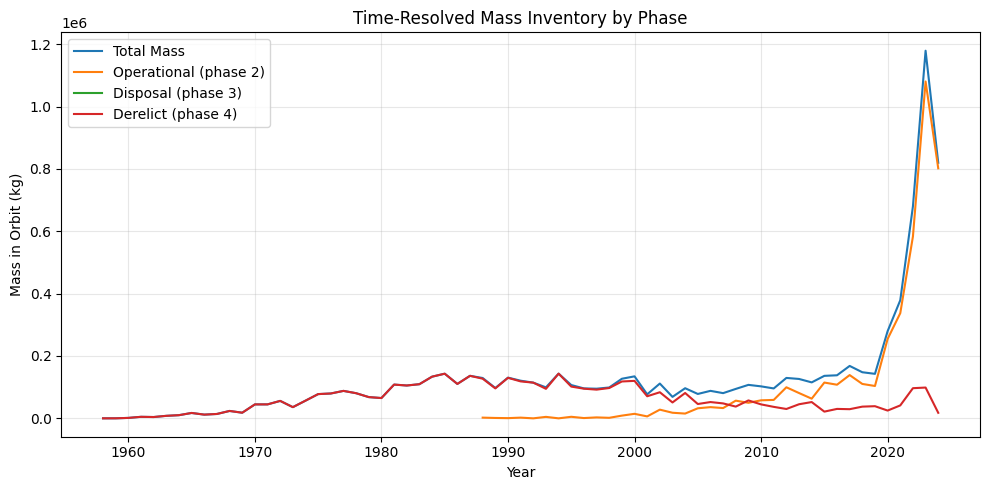

In [100]:
df = T_new.set_index('date_start')
mass_total = df['mass'].resample('A').sum()  

# 4) Mass per phase each year
mass_main    = df[df['phase']==2]['mass'].resample('A').sum()
mass_disposal= df[df['phase']==3]['mass'].resample('A').sum()
mass_debris  = df[df['phase']==4]['mass'].resample('A').sum()

plt.figure(figsize=(10,5))
plt.plot(mass_total.index.year,    mass_total,     label='Total Mass')
plt.plot(mass_main.index.year,     mass_main,      label='Operational (phase 2)')
plt.plot(mass_disposal.index.year, mass_disposal,  label='Disposal (phase 3)')
plt.plot(mass_debris.index.year,   mass_debris,    label='Derelict (phase 4)')

plt.xlabel('Year')
plt.ylabel('Mass in Orbit (kg)')
plt.title('Time-Resolved Mass Inventory by Phase')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/9y/hnc2c1bs54b27pqfzbnxv55r0000gn/T/ipykernel_26902/2241546575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_new['date_start'] = pd.to_datetime({
/var/folders/9y/hnc2c1bs54b27pqfzbnxv55r0000gn/T/ipykernel_26902/2241546575.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(annual_counts.index, rotation=45, ha='right')


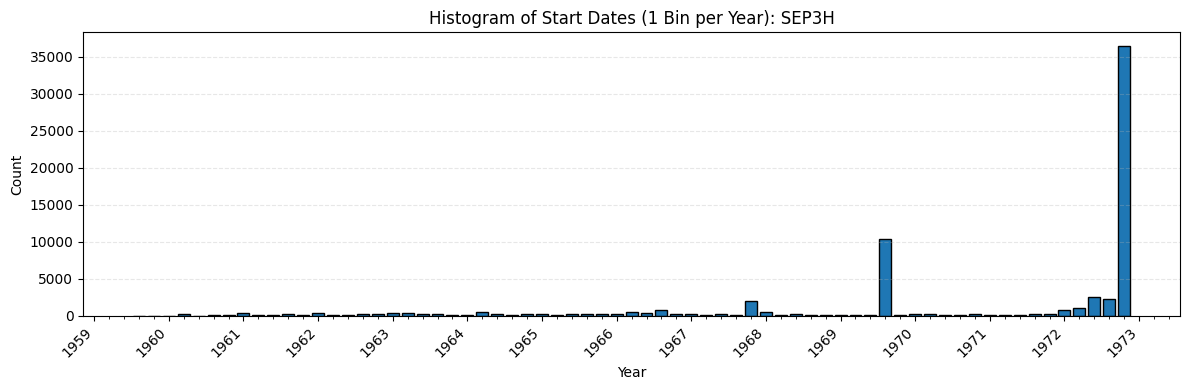

In [ ]:
# 1) Ensure you have a datetime column called date_start
T_new['date_start'] = pd.to_datetime({
    'year':  T_new.year_start.astype(int),
    'month': T_new.month_start.astype(int),
    'day':   T_new.day_start.astype(int)
})

# 2) Aggregate into one count per calendar year
annual_counts = T_new['date_start'].dt.year.value_counts().sort_index()

# 3) Plot as a bar chart, one bar per year, ticks every 5 years
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(annual_counts.index, annual_counts.values, width=0.8, edgecolor='black')

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(annual_counts.index, rotation=45, ha='right')

ax.set_title('Histogram of Start Dates (1 Bin per Year): SEP3H')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [97]:
print(T_new['date_start'].min())
print(T_new['date_start'].max())

1958-03-17 00:00:00
2024-07-04 00:00:00


In [33]:
# # 1) sim start date
# start_date = "01/01/2025"
# month, day, year = map(int, start_date.split("/"))

# # 2) Convert to Modified Julian Date
# t0 = Time(f"{year}-{month:02d}-{day:02d}", format="iso", scale="utc")
# mjd0 = t0.mjd
# print(f"Simulation t₀ = {start_date} → MJD {mjd0:.6f}")

# # 3) Filter your DataFrame
# #    Keep only objects whose mjd_start is ≤ mjd0 (i.e. in orbit by t₀)
# initial = T_new.loc[T_new['mjd_start'] <= mjd0].copy()

# # 4) Sanity check
# print(f"Total objects in table:        {len(T_new)}")
# print(f"Objects in initial population: {len(initial)}")
# print(f"Objects launched after t₀:     {(T_new['mjd_start'] > mjd0).sum()}")

# # 5) Now plot or analyze `initial` only
# #    e.g. mass histogram for initial population:
# import matplotlib.pyplot as plt
# plt.hist(initial['mass'].dropna(), bins=50, edgecolor='black')
# plt.title(f"Mass Distribution of Initial Population\n(before or on {start_date})")
# plt.xlabel("Mass (kg)")
# plt.ylabel("Count")
# plt.grid(alpha=0.4)
# plt.tight_layout()
# plt.show()


## Preliminary Plotting, All Species

In [98]:
max_mass = 10000
heavy = T_new[T_new['mass'] > max_mass]

print(f"Number of objects > {max_mass} kg: {len(heavy)}")
print(heavy['species_class'].value_counts())

# max_mass_i = 10000
# heavy_i = initial[initial['mass'] > max_mass_i]

# print(f"Number of objects > {max_mass_i} kg: {len(heavy_i)}")
# print(heavy_i['species_class'].value_counts())


Number of objects > 10000 kg: 1
species_class
Sns    1
Name: count, dtype: int64


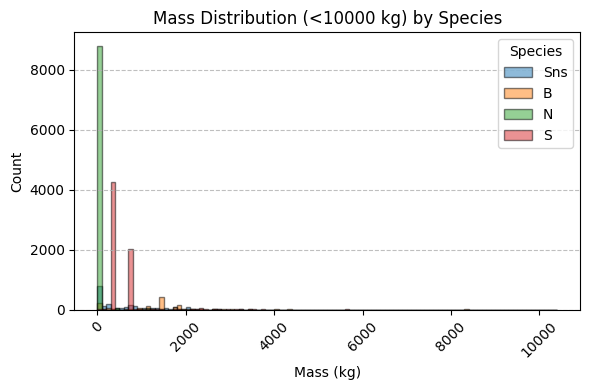

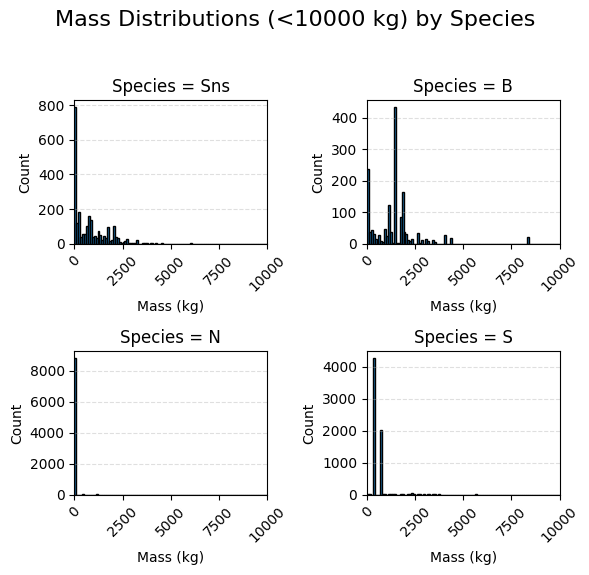

In [101]:
all_species = T_new['species_class'].dropna().unique()
bins = np.arange(0, max_mass + 500, 100)
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (T_new['mass'] < max_mass) & (T_new['species_class'] == species)
    subset = T_new.loc[mask, 'mass'].dropna()
    # overlay each species, with a bit of transparency
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Mass Distribution (<{max_mass} kg) by Species")
plt.xlabel("Mass (kg)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = T_new.loc[
        (T_new['species_class']==sp) & 
        (T_new['mass'] < max_mass),
        'mass'
    ].dropna()

    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(f"Species = {sp}")
    ax.set_xlim(0, max_mass)
    ax.set_xlabel("Mass (kg)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig.suptitle(f"Mass Distributions (<{max_mass} kg) by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


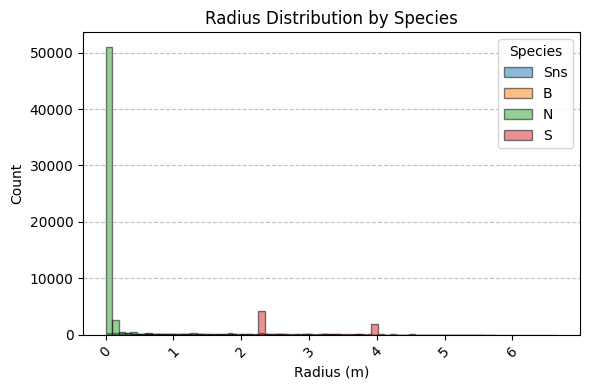

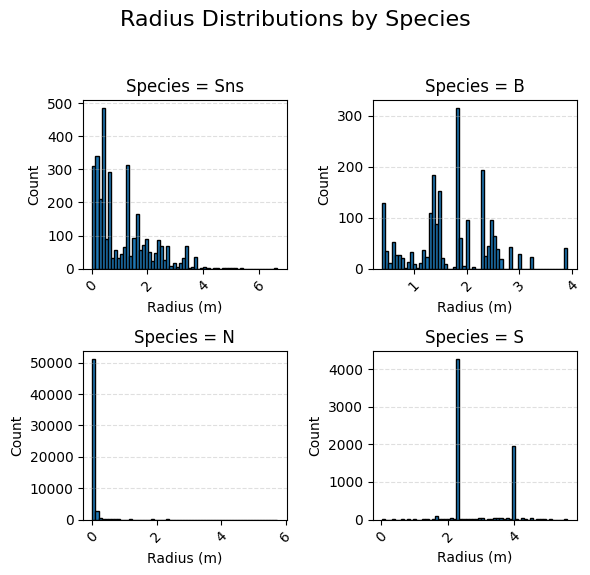

In [36]:
all_species = T_new['species_class'].dropna().unique()
bins = 60
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (T_new['species_class'] == species)
    subset = T_new.loc[mask, 'radius'].dropna()
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Radius Distribution by Species")
plt.xlabel("Radius (m)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = T_new.loc[
        (T_new['species_class']==sp),
        # (T_new['mass'] < max_mass),
        'radius'
    ].dropna()

    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(f"Species = {sp}")
    # ax.set_xlim(0, max_mass)
    ax.set_xlabel("Radius (m)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig.suptitle(f"Radius Distributions by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


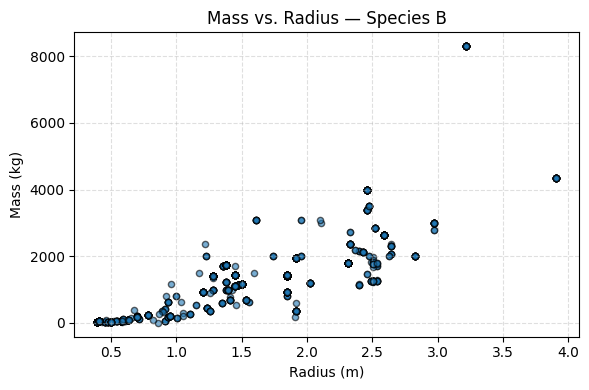

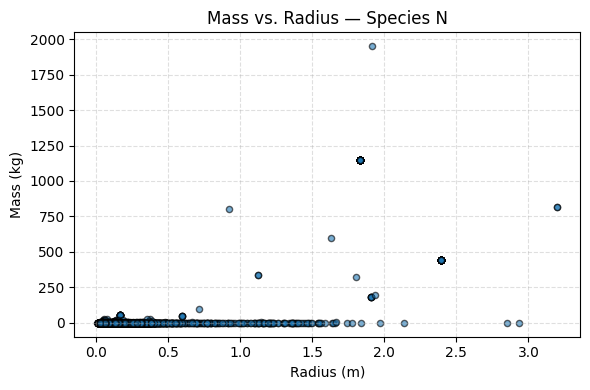

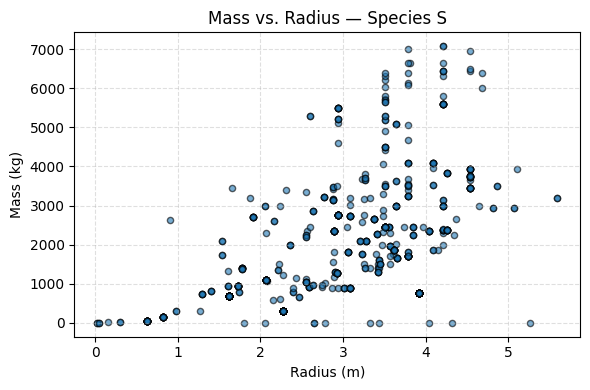

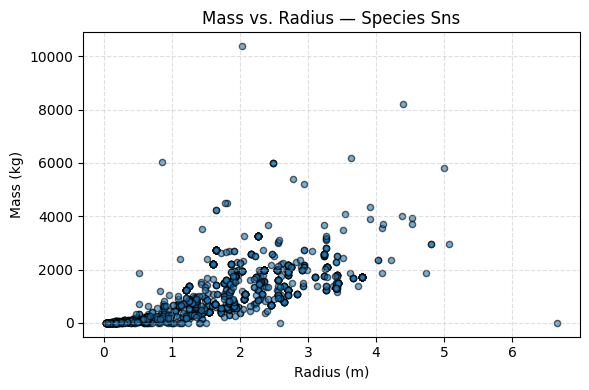

In [104]:
# pick only the rows with both mass & radius
mass_radius_df = T_new[['species_class','mass','radius']].dropna()

for sp, group in mass_radius_df.groupby('species_class'):
    plt.figure(figsize=(6,4))
    plt.scatter(
        group['radius'],
        group['mass'],
        s=20,
        alpha=0.6,
        edgecolor='k'
    )
    plt.title(f"Mass vs. Radius — Species {sp}")
    plt.xlabel("Radius (m)")
    plt.ylabel("Mass (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    # optional log scale if needed:
    # plt.xscale('log'); plt.yscale('log')
    plt.tight_layout()
    plt.show()


## Statistical Analysis

In [124]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

In [ ]:
# mass_radius_df = T_new[['species_class','mass','radius']].dropna()
species_groups = mass_radius_df.groupby('species_class')

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

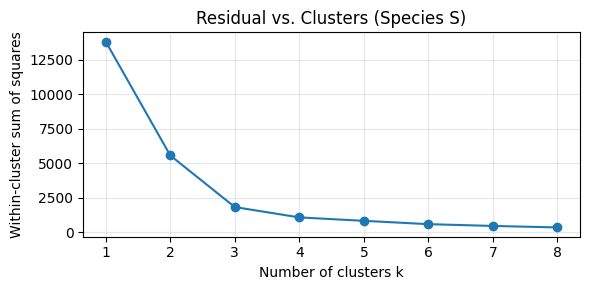

In [126]:
# 1) Prepare your data: pick only the species you want (e.g. S, station-keeping sats)
df = T_new[T_new['species_class']=='S'][['radius','mass']].dropna()
X = df.values
Xs = StandardScaler().fit_transform(X)

inertia_kmeans  = []
resid_kmedians  = []

# 2) Compute WCSS (inertia) for k = 1…8
ks = range(1,9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(Xs)
    inertia_kmeans.append(km.inertia_)  
    
    # k-medians
    kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0)
    kmn.fit(Xs)
    # sum of L1 distances to each cluster’s medoid
    resid = np.sum(kmn.inertia_)  # sklearn_extra uses ‘inertia_’ as sum of distances
    resid_kmedians.append(resid)

# 3) Plot the elbow
plt.figure(figsize=(6,3))
plt.plot(ks, inertia_kmeans, '-o', label='K-Means Inertia')
plt.xticks(ks)
plt.xlabel('Number of clusters k')
plt.ylabel('Within-cluster sum of squares')
plt.title('Residual vs. Clusters (Species S)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


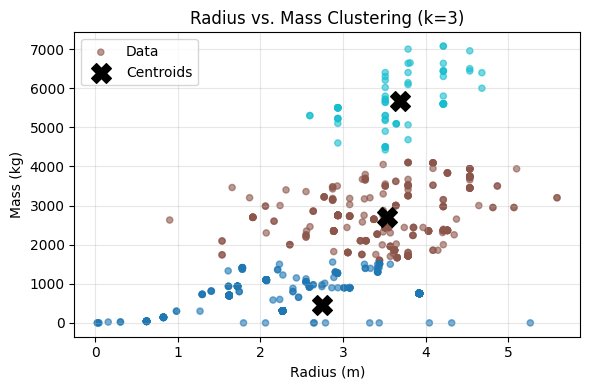

In [129]:
# 4) Choose your k (say k=2), re-fit and get centroids
k = 3
km = KMeans(n_clusters=k, random_state=0).fit(X)
labels = km.labels_
centers = km.cluster_centers_

# 5) Scatter Area vs Mass with centroids
plt.figure(figsize=(6,4))
plt.scatter(df['radius'], df['mass'], c=labels, cmap='tab10', s=20, alpha=0.6, label='Data')
plt.scatter(centers[:,0], centers[:,1], 
            marker='X', s=200, c='black', label='Centroids')
plt.xlabel('Radius (m)')
plt.ylabel('Mass (kg)')
plt.title(f'Radius vs. Mass Clustering (k={k})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### SNS Species

In [ ]:
# SNS SPECIES
sns = T_new[T_new['species_class'] == 'Sns']
max_mass = 2500
sns_mass_filt = sns.loc[(sns['mass'] < max_mass), 'mass'].dropna()

# local peaks in histogram
bin_width = 20 # 20 kg per bin
bins = np.arange(0, max_mass + bin_width, bin_width)
hist, edges = np.histogram(sns_mass_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
peak_centers = centers[peak_idx]
peak_heights = hist[peak_idx]

threshold = 0.1 * hist.max()   # e.g. only peaks ≥10% of the tallest bar
valid = peak_heights >= threshold
peak_idx = peak_idx[valid]
peak_centers = centers[peak_idx]
peak_heights = peak_heights[valid]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(sns_mass_filt, bins=bins, edgecolor='black')
for x, h in zip(peak_centers, peak_heights):
    ax.axvline(x, color='red', linestyle='--')
    ax.text(x, h + max(hist)*0.02, f"{x:.0f} kg",
            rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("SNS Mass Distribution (<2500 kg)")
ax.set_xlabel("Mass (kg)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()




sns_radius_filt = sns['radius'].dropna()


rad_max = sns_radius_filt.max()
bin_width = 0.1 # 0.1 m per bin
bins = np.arange(0, rad_max + bin_width, bin_width)
hist, edges = np.histogram(sns_radius_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
peak_centers = centers[peak_idx]
peak_heights = hist[peak_idx]

threshold = 0.1 * hist.max()   # e.g. only peaks ≥10% of the tallest bar
valid = peak_heights >= threshold
peak_idx = peak_idx[valid]
peak_centers = centers[peak_idx]
peak_heights = peak_heights[valid]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(sns_radius_filt, bins=bins, edgecolor='black')
for x, h in zip(peak_centers, peak_heights):
    ax.axvline(x, color='red', linestyle='--')
    ax.text(x, h + max(hist)*0.02, f"{x:.2f} m",
            rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("SNS Radius Distribution")
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()



In [ ]:
# S SPECIES
sns = T_new[T_new['species_class'] == 'S']
max_mass = 2500
sns_mass_filt = sns.loc[(sns['mass'] < max_mass), 'mass'].dropna()

# local peaks in histogram
bin_width = 20 # 20 kg per bin
bins = np.arange(0, max_mass + bin_width, bin_width)
hist, edges = np.histogram(sns_mass_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
peak_centers = centers[peak_idx]
peak_heights = hist[peak_idx]

threshold = 0.1 * hist.max()   # e.g. only peaks ≥10% of the tallest bar
valid = peak_heights >= threshold
peak_idx = peak_idx[valid]
peak_centers = centers[peak_idx]
peak_heights = peak_heights[valid]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(sns_mass_filt, bins=bins, edgecolor='black')
for x, h in zip(peak_centers, peak_heights):
    ax.axvline(x, color='red', linestyle='--')
    ax.text(x, h + max(hist)*0.02, f"{x:.0f} kg",
            rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("S Mass Distribution (<2500 kg)")
ax.set_xlabel("Mass (kg)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()




sns_radius_filt = sns['radius'].dropna()


rad_max = sns_radius_filt.max()
bin_width = 0.1 # 0.1 m per bin
bins = np.arange(0, rad_max + bin_width, bin_width)
hist, edges = np.histogram(sns_radius_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
peak_centers = centers[peak_idx]
peak_heights = hist[peak_idx]

threshold = 0.1 * hist.max()   # e.g. only peaks ≥10% of the tallest bar
valid = peak_heights >= threshold
peak_idx = peak_idx[valid]
peak_centers = centers[peak_idx]
peak_heights = peak_heights[valid]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(sns_radius_filt, bins=bins, edgecolor='black')
for x, h in zip(peak_centers, peak_heights):
    ax.axvline(x, color='red', linestyle='--')
    ax.text(x, h + max(hist)*0.02, f"{x:.2f} m",
            rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("S Radius Distribution")
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()



#### B SPECIES

In [ ]:
# B SPECIES
b = T_new[T_new['species_class'] == 'B']
max_mass = 5000
b_mass_filt = b.loc[(b['mass'] < max_mass), 'mass'].dropna()

# local peaks in histogram
bin_width = 20 # 20 kg per bin
bins = np.arange(0, max_mass + bin_width, bin_width)
hist, edges = np.histogram(b_mass_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
heights = hist[peak_idx]
threshold = 1200
peaks = peak_idx[heights >= threshold]

peak_centers = centers[peaks]
peak_heights = hist[peaks]
print(peak_centers)


fig, ax = plt.subplots(figsize=(6,4))
ax.hist(b_mass_filt, bins=bins, edgecolor='black')
for x, h in zip(peak_centers, peak_heights):
    ax.axvline(x, color='red', linestyle='--')
    ax.text(x, h + max(hist)*0.02, f"{x:.0f} kg",
            rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("B Mass Distribution (<5000 kg)")
ax.set_xlabel("Mass (kg)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()




b_radius_filt = b['radius'].dropna()


rad_max = b_radius_filt.max()
bin_width = 0.1 # 0.1 m per bin
bins = np.arange(0, rad_max + bin_width, bin_width)
hist, edges = np.histogram(b_radius_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
heights = hist[peak_idx]
threshold = 0.1 * hist.max()
peaks = peak_idx[heights >= threshold]

peak_centers = centers[peaks]
peak_heights = hist[peaks]


fig, ax = plt.subplots(figsize=(6,4))
ax.hist(b_radius_filt, bins=bins, edgecolor='black')
for x, h in zip(peak_centers, peak_heights):
    ax.axvline(x, color='red', linestyle='--')
    ax.text(x, h + max(hist)*0.02, f"{x:.2f} m",
            rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("B Radius Distribution")
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()



#### N SPECIES

In [ ]:
n = T_new[T_new['species_class'] == 'N']
print(n['mass'].describe())

In [ ]:
# N SPECIES
b = T_new[T_new['species_class'] == 'N']
max_mass = 0.2
b_mass_filt = b.loc[(b['mass'] < max_mass), 'mass'].dropna()

# local peaks in histogram
bin_width = 0.001 # 0.001 kg per bin
bins = np.arange(0, max_mass + bin_width, bin_width)
hist, edges = np.histogram(b_mass_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
heights = hist[peak_idx]
threshold = 1200
peaks = peak_idx[heights >= threshold]

peak_centers = centers[peaks]
peak_heights = hist[peaks]
print(peak_centers)


fig, ax = plt.subplots(figsize=(6,4))
ax.hist(b_mass_filt, bins=bins, edgecolor='black')
# for x, h in zip(peak_centers, peak_heights):
#     ax.axvline(x, color='red', linestyle='--')
    # ax.text(x, h + max(hist)*0.02, f"{x:.0f} kg",
    #         rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("N Mass Distribution (<2500 kg)")
ax.set_xlabel("Mass (kg)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()




b_radius_filt = b['radius'].dropna()


rad_max = b_radius_filt.max()
bin_width = 0.01 # 0.01 m per bin
bins = np.arange(0, rad_max + bin_width, bin_width)
hist, edges = np.histogram(b_radius_filt, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

peak_idx = np.where(
    (hist[1:-1] > hist[:-2]) &
    (hist[1:-1] > hist[2:])
)[0] + 1
heights = hist[peak_idx]
threshold = 0.1 * hist.max()
peaks = peak_idx[heights >= threshold]

peak_centers = centers[peaks]
peak_heights = hist[peaks]


fig, ax = plt.subplots(figsize=(6,4))
ax.hist(b_radius_filt, bins=bins, edgecolor='black')
for x, h in zip(peak_centers, peak_heights):
    ax.axvline(x, color='red', linestyle='--')
    ax.text(x, h + max(hist)*0.02, f"{x:.2f} m",
            rotation=45, ha='left', va='bottom', color='red', fontsize=8)

ax.set_title("N Radius Distribution")
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Count")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()



In [ ]:
# histograms to understand mass/radius of different species binning
# check that json countries work
# --> plotting

### Use this code - as a template -  to be able to explore the data. 

In [ ]:
import matplotlib.pyplot as plt

# Filter active satellites
active_satellites = T[T['obj_type'] == 2]

# Get counts of maneuverability values
maneuver_counts = active_satellites['maneuverable'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(maneuver_counts.index.astype(str), maneuver_counts.values, color='blue', alpha=0.7)
plt.xlabel('Maneuverable (0 = No, 1 = Yes)')
plt.ylabel('Number of Active Satellites')
plt.title('Maneuverability of Active Satellites')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Now we can check which filters work. 

In [ ]:
# This function has been taken for pyssem and allows you to pass a list of species queries and test it. 

def assign_species_to_population(T, species_mapping):
    """
    Applies a list of pandas query strings to assign species classes to the population.
    
    :param T: pandas.DataFrame representing the population
    :param species_mapping: list of assignment strings (e.g., T.loc[...] = ...)
    :return: updated DataFrame with 'species_class' assigned
    """
    # Initialize the column
    T['species_class'] = "Unknown"

    # Apply each mapping rule via exec
    for rule in species_mapping:
        try:
            exec(rule)
        except Exception as e:
            print(f"Error applying rule: {rule}\n\t{e}")

    # Print summary of resulting species_class assignments
    print("\nSpecies class distribution:")
    print(T['species_class'].value_counts())

    # Remove all objects that are still unknown
    try:
        T = T[T['species_class'] != "Unknown"]
        print(f"\n{T['species_class'].value_counts()['Unknown']} objects/rows are being removed.")
    except KeyError:
        print("No unknown species classes found.")

    return T

In [ ]:
# Now we can test different configurations

species_configuration = [
      "T.loc[(T['phase'] == 2) & (T['obj_type'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'S'",
      "T.loc[(T['obj_type'] == 2) & (T['maneuverable'] == 0), 'species_class'] = 'Sns'",
      "T.loc[(T['obj_type'] >= 3), 'species_class'] = 'N'",
      "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
]

# Apply the species configuration
T_new = assign_species_to_population(T, species_configuration)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert epoch_start_datetime to year if it's not already a column
if 'year_start' not in T_new.columns:
    T_new['year_start'] = T_new['epoch_start_datetime'].dt.year

# Group by year and species_class
launch_counts = T_new.groupby(['year_start', 'species_class']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
for species in launch_counts.columns:
    plt.plot(launch_counts.index, launch_counts[species], label=species)

plt.title("Object Starts per Year by Species Class")
plt.xlabel("Year")
plt.ylabel("Number of Objects Started")
plt.xlim(2025, 2125)
plt.grid(True)
plt.legend(title="Species Class")
plt.tight_layout()
plt.show()

In [ ]:
# load the results.json data
import json
import os
import matplotlib.pyplot as plt

# Define the path to the JSON file
json_file_path = '/Users/indigobrownhall/Code/pyssem/figures/SEP2/results.json'

# Check if the file exists
if not os.path.exists(json_file_path):
    raise FileNotFoundError(f"The file {json_file_path} does not exist.")

# Load the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Extract time and launch entries
times = data['times']
launch_entries = data['launch']

# Plot each species' launch counts
plt.figure(figsize=(12, 6))

for entry in launch_entries:
    species = entry['species']
    counts = entry['counts']
    plt.plot(times, counts, label=species)

plt.title('Cumulative Launches Over Time by Species')
plt.xlabel('Time')
plt.ylabel('Cumulative Launches')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()